In [1]:
# hide
# default_exp models

from nbdev.showdoc import *

# InstanceCMR
> Context Maintenance and Retrieval within an Instance-Based Architecture

| Structure Type        | Symbol            | Name                    | Description                                                 |
|:----------------------|:------------------|:------------------------|:------------------------------------------------------------|
| Architecture          |                   |                         |                                                             |
|                       | $M$               | memory                  | Array of accumulated memory traces                          |
|                       | $C$               | temporal context        | A recency-weighted average of encoded items                 |
|                       | $F$               | item features           | Current pattern of item feature unit activations            |
| Context Updating      |                   |                         |                                                             |
|                       | ${\beta}_{enc}$   | encoding drift rate     | Rate of context drift during item encoding                  |
|                       | ${\beta}_{start}$ | start drift rate        | Amount of start-list context retrieved at start of recall   |
|                       | ${\beta}_{rec}$   | recall drift rate       | Rate of context drift during recall                         |
| Associative Structure |                   |                         |                                                             |
|                       | ${\alpha}$        | shared support          | Amount of support items initially have for one another      |
|                       | ${\delta}$        | item support            | Initial pre-experimental contextual self-associations       |
|                       | ${\gamma}$        | learning rate           | Amount of experimental context retrieved by a recalled item |
|                       | ${\phi}_{s}$      | primacy scale           | Scaling of primacy gradient on trace activations            |
|                       | ${\phi}_{d}$      | primacy decay           | Rate of decay of primacy gradient                           |
| Retrieval Dynamics    |                   |                         |                                                             |
|                       | ${\tau}$          | choice sensitivity      | Exponential weighting of similarity-driven activation       |
|                       | ${\theta}_{s}$    | stop probability scale  | Scaling of the stop probability over output position        |
|                       | ${\theta}_{r}$    | stop probability growth | Rate of increase in stop probability over output position   |
|                       |                   |                         |                                                             |

In [2]:
# export
# hide

import math
import numpy as np
from numba import float64, int32, boolean
from numba.experimental import jitclass

spec = [
    ('item_count', int32), 
    ('encoding_drift_rate', float64),
    ('start_drift_rate', float64),
    ('recall_drift_rate', float64),
    ('shared_support', float64),
    ('item_support', float64),
    ('learning_rate', float64),
    ('primacy_scale', float64),
    ('primacy_decay', float64),
    ('stop_probability_scale', float64),
    ('stop_probability_growth', float64),
    ('choice_sensitivity', float64),
    ('context_sensitivity', float64),
    ('feature_sensitivity', float64),
    ('context', float64[::1]),
    ('preretrieval_context', float64[::1]),
    ('recall', float64[::1]),
    ('retrieving', boolean),
    ('recall_total', int32),
    ('item_weighting', float64[::1]),
    ('context_weighting', float64[::1]),
    ('all_weighting', float64[::1]),
    ('probabilities', float64[::1]),
    ('memory', float64[:,::1]),
    ('encoding_index', int32),
    ('items', float64[:,::1])
]

In [3]:
# export
# hide

@jitclass(spec)
class InstanceCMR:

    def __init__(
        self, item_count, presentation_count, encoding_drift_rate, 
        start_drift_rate, recall_drift_rate, shared_support,
        item_support, learning_rate, primacy_scale, primacy_decay, 
        stop_probability_scale, stop_probability_growth, choice_sensitivity, 
        context_sensitivity, feature_sensitivity):

        # store initial parameters
        self.item_count = item_count
        self.encoding_drift_rate = encoding_drift_rate
        self.start_drift_rate = start_drift_rate
        self.recall_drift_rate = recall_drift_rate
        self.shared_support = shared_support
        self.item_support = item_support
        self.learning_rate = learning_rate
        self.primacy_scale = primacy_scale
        self.primacy_decay = primacy_decay
        self.stop_probability_scale = stop_probability_scale
        self.stop_probability_growth = stop_probability_growth
        self.choice_sensitivity = choice_sensitivity
        self.context_sensitivity = context_sensitivity
        self.feature_sensitivity = feature_sensitivity
        
        # at the start of the list context is initialized with a state 
        # orthogonal to the pre-experimental context associated with the set of items
        self.context = np.zeros(item_count + 1)
        self.context[0] = 1
        self.preretrieval_context = self.context
        self.recall = np.zeros(item_count) # recalls has at most `item_count` entries
        self.retrieving = False
        self.recall_total = 0

        # predefine activation weighting vectors
        self.item_weighting = np.ones(item_count+presentation_count)
        self.context_weighting = np.ones(item_count+presentation_count)
        self.item_weighting[item_count:] = learning_rate
        self.context_weighting[item_count:] = \
            primacy_scale * np.exp(-primacy_decay * np.arange(presentation_count)) + 1
        self.all_weighting = self.item_weighting * self.context_weighting

        # preallocate for outcome_probabilities
        self.probabilities = np.zeros((item_count + 1))

        # initialize memory
        # we now conceptualize it as a pairing of two stores Mfc and Mcf respectively
        # representing feature-to-context and context-to-feature associations
        mfc = np.eye(item_count, item_count + 1, 1) * (1 - learning_rate)
        mcf = np.ones((item_count, item_count)) * shared_support
        for i in range(item_count):
            mcf[i, i] = item_support
        mcf = np.hstack((np.zeros((item_count, 1)), mcf))
        self.memory = np.zeros((item_count + presentation_count, item_count * 2 + 2))
        self.memory[:item_count,] = np.hstack((mfc, mcf))
        self.encoding_index = item_count
        self.items = np.eye(item_count, item_count + 1, 1)

    def experience(self, experiences):

        for i in range(len(experiences)):
            self.memory[self.encoding_index, :self.item_count+1] = experiences[i]
            self.update_context(self.encoding_drift_rate, self.memory[self.encoding_index])
            self.memory[self.encoding_index, self.item_count+1:] = self.context
            self.encoding_index += 1

    def update_context(self, drift_rate, experience=None):

        # first pre-experimental or initial context is retrieved
        if experience is not None:
            context_input = self.echo(experience)[self.item_count + 1:]
            context_input = context_input / np.sqrt(np.sum(np.square(context_input))) # norm to length 1
        else:
            context_input = np.zeros((self.item_count+1))
            context_input[0] = 1

        # updated context is sum of context and input, modulated by rho to have len 1 and some drift_rate
        rho = np.sqrt(1 + np.square(drift_rate) * (np.square(self.context * context_input) - 1)) - (
                drift_rate * (self.context * context_input))
        self.context = (rho * self.context) + (drift_rate * context_input)

    def echo(self, probe):

        return np.dot(self.activations(probe), self.memory[:self.encoding_index])

    def activations(self, probe):

        # computes and cubes similarity value to find activation for each trace in memory
        activation = np.dot(self.memory[:self.encoding_index], probe) / (
            np.sqrt(np.sum(np.square(self.memory[:self.encoding_index]), axis=1)) * np.sqrt(
                np.sum(np.square(probe))))

        # weight activations based on whether probe contains item or contextual features or both
        if np.any(probe[:self.item_count + 1]):
            if np.any(probe[self.item_count + 1:]):
                # both mfc and mcf weightings, see below
                activation *= self.all_weighting[:self.encoding_index]
            else:
                # mfc weightings - scale by gamma for each experimental trace
                activation *= self.item_weighting[:self.encoding_index]
            activation = np.power(activation, self.context_sensitivity)
        else:
            # mcf weightings - scale by primacy/attention function based on experience position
            activation *= self.context_weighting[:self.encoding_index]
            if self.feature_sensitivity != 1.0:
                activation = np.power(activation, self.feature_sensitivity)
            else:
                activation = np.power(activation, self.context_sensitivity)
            
        return activation + 10e-7

    def outcome_probabilities(self, activation_cue):

        echo = self.echo(activation_cue)[1:self.item_count+1]
        echo = np.power(echo, self.choice_sensitivity)
        
        self.probabilities = np.zeros((self.item_count + 1))
        self.probabilities[0] = min(self.stop_probability_scale * np.exp(
            self.recall_total * self.stop_probability_growth), 1.0 - (self.item_count * 10e-7))

        if self.probabilities[0] < 1:
            for already_recalled_item in self.recall[:self.recall_total]:
                echo[int(already_recalled_item)] = 0
        self.probabilities[1:] = (1-self.probabilities[0]) * echo / np.sum(echo)
        
        return self.probabilities

    def free_recall(self, steps=None):

        # some pre-list context is reinstated before initiating recall
        if not self.retrieving:
            self.recall = np.zeros(self.item_count)
            self.recall_total = 0
            self.preretrieval_context = self.context
            self.update_context(self.start_drift_rate)
            self.retrieving = True
            
        # number of items to retrieve is infinite if steps is unspecified
        if steps is None:
            steps = self.item_count - self.recall_total
        steps = self.recall_total + steps

        # at each recall attempt
        while self.recall_total < steps:

            # the current state of context is used as a retrieval cue to 
            # attempt recall of a studied item compute outcome probabilities 
            # and make choice based on distribution
            outcome_probabilities = self.outcome_probabilities(
                np.hstack((np.zeros(self.item_count + 1), self.context)))
            if np.any(outcome_probabilities[1:]):
                choice = np.sum(
                    np.cumsum(outcome_probabilities) < np.random.rand())
            else:
                choice = 0

            # resolve and maybe store outcome
            # we stop recall if no choice is made (0)
            if choice == 0:
                self.retrieving = False
                self.context = self.preretrieval_context
                break
            self.recall[self.recall_total] = choice - 1
            self.recall_total += 1
            self.update_context(self.recall_drift_rate,
                                np.hstack((self.items[choice - 1], 
                                           np.zeros(self.item_count + 1))))
        return self.recall[:self.recall_total]
    
    def force_recall(self, choice=None):

        if not self.retrieving:
            self.recall = np.zeros(self.item_count)
            self.recall_total = 0
            self.preretrieval_context = self.context
            self.update_context(self.start_drift_rate)
            self.retrieving = True

        if choice is None:
            pass
        elif choice > 0:
            self.recall[self.recall_total] = choice - 1
            self.recall_total += 1
            self.update_context(
                self.recall_drift_rate, 
                np.hstack((self.items[choice - 1], 
                           np.zeros(self.item_count + 1))))
        else:
            self.retrieving = False
            self.context = self.preretrieval_context
        return self.recall[:self.recall_total]

In [4]:
try:
    show_doc(InstanceCMR, doc_string=False)
except:
    pass

<h2 id="InstanceCMR" class="doc_header"><code>class</code> <code>InstanceCMR</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>InstanceCMR</code>(**\*`args`**, **\*\*`kwargs`**) :: [`InstanceCMR`](/instance_cmr/Instance_CMR.html#InstanceCMR)



In [5]:
try:
    show_doc(InstanceCMR.__init__, doc_string=False)
except:
    pass

<h4 id="InstanceCMR.__init__" class="doc_header"><code>InstanceCMR.__init__</code><a href="__main__.py#L7" class="source_link" style="float:right">[source]</a></h4>

> <code>InstanceCMR.__init__</code>(**`item_count`**, **`presentation_count`**, **`encoding_drift_rate`**, **`start_drift_rate`**, **`recall_drift_rate`**, **`shared_support`**, **`item_support`**, **`learning_rate`**, **`primacy_scale`**, **`primacy_decay`**, **`stop_probability_scale`**, **`stop_probability_growth`**, **`choice_sensitivity`**, **`context_sensitivity`**, **`feature_sensitivity`**)



In [6]:
try:
    show_doc(InstanceCMR.experience, doc_string=False)
except:
    pass

<h4 id="InstanceCMR.experience" class="doc_header"><code>InstanceCMR.experience</code><a href="__main__.py#L63" class="source_link" style="float:right">[source]</a></h4>

> <code>InstanceCMR.experience</code>(**`experiences`**)



In [7]:
try:
    show_doc(InstanceCMR.update_context, doc_string=False)
except:
    pass

<h4 id="InstanceCMR.update_context" class="doc_header"><code>InstanceCMR.update_context</code><a href="__main__.py#L71" class="source_link" style="float:right">[source]</a></h4>

> <code>InstanceCMR.update_context</code>(**`drift_rate`**, **`experience`**=*`None`*)



In [8]:
try:
    show_doc(InstanceCMR.activations, doc_string=False)
except:
    pass

<h4 id="InstanceCMR.activations" class="doc_header"><code>InstanceCMR.activations</code><a href="__main__.py#L90" class="source_link" style="float:right">[source]</a></h4>

> <code>InstanceCMR.activations</code>(**`probe`**)



In [9]:
try:
    show_doc(InstanceCMR.echo, doc_string=False)
except:
    pass

<h4 id="InstanceCMR.echo" class="doc_header"><code>InstanceCMR.echo</code><a href="__main__.py#L86" class="source_link" style="float:right">[source]</a></h4>

> <code>InstanceCMR.echo</code>(**`probe`**)



In [10]:
try:
    show_doc(InstanceCMR.outcome_probabilities, doc_string=False)
except:
    pass

<h4 id="InstanceCMR.outcome_probabilities" class="doc_header"><code>InstanceCMR.outcome_probabilities</code><a href="__main__.py#L116" class="source_link" style="float:right">[source]</a></h4>

> <code>InstanceCMR.outcome_probabilities</code>(**`activation_cue`**)



In [11]:
try:
    show_doc(InstanceCMR.free_recall, doc_string=False)
except:
    pass

<h4 id="InstanceCMR.free_recall" class="doc_header"><code>InstanceCMR.free_recall</code><a href="__main__.py#L132" class="source_link" style="float:right">[source]</a></h4>

> <code>InstanceCMR.free_recall</code>(**`steps`**=*`None`*)



In [12]:
try:
    show_doc(InstanceCMR.force_recall, doc_string=False)
except:
    pass

<h4 id="InstanceCMR.force_recall" class="doc_header"><code>InstanceCMR.force_recall</code><a href="__main__.py#L174" class="source_link" style="float:right">[source]</a></h4>

> <code>InstanceCMR.force_recall</code>(**`choice`**=*`None`*)



# Demo
To play with the model, set parameters below and run the cell.

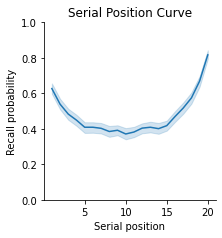

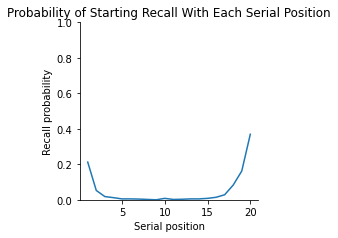

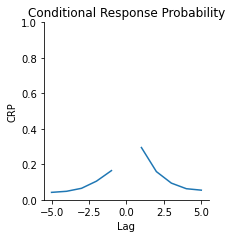

In [13]:
from instance_cmr.model_analysis import temporal_organization_analyses

parameters = {
    'item_count': 20,
    'presentation_count': 20,
    'encoding_drift_rate': .8,
    'start_drift_rate': .7,
    'recall_drift_rate': .8,
    'shared_support': 0.01,
    'item_support': 1.0,
    'learning_rate': .3,
    'primacy_scale': 1,
    'primacy_decay': 1,
    'stop_probability_scale': 0.01,
    'stop_probability_growth': 0.3,
    'choice_sensitivity': 2,
    'feature_sensitivity': 1,
    'context_sensitivity': 1
}

experiment_count = 1000

model = InstanceCMR(**parameters)
temporal_organization_analyses(model, experiment_count)